In [1]:
import csv
import numpy as np

signal = []
label = []

with open('C:\\Users\\yurui\\Desktop\\item\\heart\\data\\train.csv','r') as f:
    reader = csv.DictReader(f)
    for line in reader:
        signal.append([float(num) for num in line['heartbeat_signals'].split(',')])
        label.append(int(float(line['label'])))


In [3]:
class StaticValue:
    def __init__(self):
        self.y1 = 0
        self.y2 = 0

    def get_y1(self):
        return self.y1

    def set_y1(self,x):
        self.y1 = x

    def get_y2(self):
        return self.y2

    def set_y2(self,x):
        self.y2 = x

def low_pass_filter(X,staticvalue):
    res = []
    for i in range(len(X)):
        if i < 6:
            res.append(lp(X[i],0,0,staticvalue))
        elif i <12:
            res.append(lp(X[i],X[i-6],0,staticvalue))
        else:
            res.append(lp(X[i],X[i-6],X[i-12],staticvalue))
    return res

def high_pass_filter(X,staticvalue):
    res = []
    for i in range(len(X)):
        if i < 16:
            res.append(hp(X[i],0,0,staticvalue))
        elif i < 32:
            res.append(hp(X[i],X[i-16],0,staticvalue))
        else:
            res.append(hp(X[i],X[i-16],X[i-32],staticvalue))
    return res

def lp(xt,xt_6,xt_12,staticvalue):
    y1 = staticvalue.get_y1()
    y2 = staticvalue.get_y2()
    res = 2*y1 - y2 + xt - 2*xt_6 + xt_12
    staticvalue.set_y2(y1)
    staticvalue.set_y1(res)
    return res

def hp(xt,xt_16,xt_32,staticvalue):
    y1 = staticvalue.get_y1()
    res = 32*xt_16 - y1 - xt + xt_32
    staticvalue.set_y1(res)
    return res

def derivative(X):
    res = []
    for i in range(len(X)):
        if i==0:
            res.append(1/8*(2*X[i+1]+X[i+2]))
        elif i==1:
            res.append(1/8*(-2*X[i-1]+2*X[i+1]+X[i+2]))
        elif i==len(X)-2:
            res.append(1/8*(-X[i-2]-2*X[i-1]+2*X[i+1]))
        elif i==len(X)-1:
            res.append(1/8*(-X[i-2]-2*X[i-1]))
        else:
            res.append(1/8*(-X[i-2]-2*X[i-1]+2*X[i+1]+X[i+2]))
    return res

def filter(X):
    lp_static = StaticValue()
    hp_static = StaticValue()
    res = derivative(high_pass_filter(low_pass_filter(X,lp_static),hp_static))
    return res



In [3]:
import random
from keras.utils.np_utils import to_categorical
import numpy as np
import tensorflow as tf

signal_filt = []
train_split = 0.8
valid_split = 0.1
test_split = 0.1

for sig in signal:
    signal_filt.append(filter(sig))

label = np.array(label)
label = to_categorical(label)

signal_filt = np.array(random.sample(signal_filt,len(signal_filt)))
signal_filt = np.expand_dims(signal_filt,-1)

train_signal = np.array(signal_filt[0:int(len(signal_filt) * train_split)])
train_label = np.array(label[0:int(len(label)*train_split)])
valid_signal = np.array(signal_filt[len(train_signal):len(train_signal) +int(len(signal_filt)*valid_split)])
valid_label = np.array(label[len(train_label):len(train_label) + int(len(label)*valid_split)])
test_signal = np.array(signal_filt[len(train_signal) + len(valid_signal):len(signal_filt)])
test_label = np.array(label[len(train_label) + len(valid_label):len(label)])

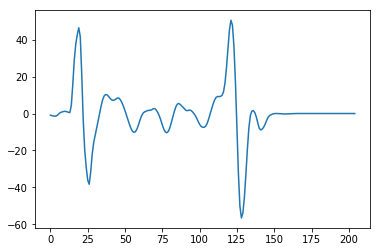

In [4]:
import matplotlib.pyplot as plt
#plt.plot(signal[0])
lp_static = StaticValue()
hp_static = StaticValue()
X = low_pass_filter(signal[105],lp_static)
#plt.plot(X)
X = high_pass_filter(X,hp_static)
#plt.plot(X)
res = derivative(X)
plt.plot(res)
plt.show()

In [7]:
train_feature =  [np.mean(train_signal,axis = 1),np.std(train_signal,axis=1),np.max(train_signal,axis=1),np.min(train_signal,axis=1)]
valid_feature =  [np.mean(valid_signal,axis = 1),np.std(valid_signal,axis=1),np.max(valid_signal,axis=1),np.min(valid_signal,axis=1)]
test_feature =  [np.mean(test_signal,axis = 1),np.std(test_signal,axis=1),np.max(test_signal,axis=1),np.min(test_signal,axis=1)]


In [11]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU,BatchNormalization,Conv1D,MaxPooling1D,GlobalAveragePooling1D,LSTM,Bidirectional,AveragePooling1D,Flatten
from keras.optimizers import Adam,SGD
from keras import regularizers
import keras
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
print('环境设置成功!')

model = Sequential(name = 'CNN')
model.add(Conv1D(32,10,padding = 'valid',batch_input_shape = (None,205,1)))
model.add(Conv1D(64,10,padding = 'valid'))
model.add(AveragePooling1D(4))
model.add(Dropout(0.1))
model.add(Conv1D(128,1,padding = 'valid'))
model.add(Conv1D(256,1,padding = 'valid'))
model.add(AveragePooling1D(4))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64,activation='sigmoid'))
model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                metrics=['accuracy'])

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="C:\\Users\\yurui\\Desktop\\item\\heart\\log\\log")

history = model.fit(train_signal,train_label,validation_data=(valid_signal,valid_label),epochs = 500,batch_size = 256,verbose = 2,callbacks = [tensorboard_callback])

model.summary()


环境设置成功!
Epoch 1/500
313/313 - 4s - loss: 1.0211 - accuracy: 0.6297 - val_loss: 0.9860 - val_accuracy: 0.6499
Epoch 2/500
313/313 - 3s - loss: 0.9930 - accuracy: 0.6424 - val_loss: 0.9837 - val_accuracy: 0.6501
Epoch 3/500
313/313 - 3s - loss: 0.9913 - accuracy: 0.6424 - val_loss: 0.9829 - val_accuracy: 0.6502
Epoch 4/500
313/313 - 3s - loss: 0.9907 - accuracy: 0.6424 - val_loss: 0.9818 - val_accuracy: 0.6502
Epoch 5/500
313/313 - 3s - loss: 0.9902 - accuracy: 0.6424 - val_loss: 0.9840 - val_accuracy: 0.6502
Epoch 6/500
313/313 - 3s - loss: 0.9897 - accuracy: 0.6424 - val_loss: 0.9824 - val_accuracy: 0.6502
Epoch 7/500
313/313 - 3s - loss: 0.9892 - accuracy: 0.6424 - val_loss: 0.9830 - val_accuracy: 0.6502
Epoch 8/500
313/313 - 3s - loss: 0.9890 - accuracy: 0.6424 - val_loss: 0.9825 - val_accuracy: 0.6503
Epoch 9/500
313/313 - 3s - loss: 0.9884 - accuracy: 0.6424 - val_loss: 0.9832 - val_accuracy: 0.6502
Epoch 10/500


KeyboardInterrupt: 

In [6]:
import numpy as np
predict_label = model.predict(test_signal,batch_size=256)
sums = 0
for i in range(len(predict_label)):
    sums += np.sum(np.abs(predict_label[i] - test_label[i]))
print(sums)

10667.755117803812


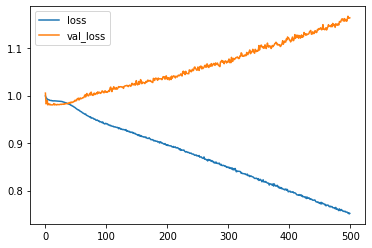

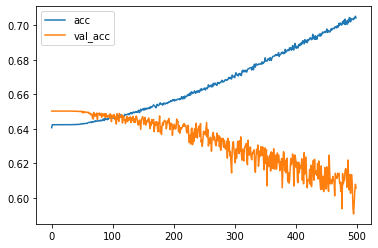

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label = 'acc')
plt.plot(history.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()